In [1]:
import matplotlib.pyplot as plt
import numpy as np
from bs4 import BeautifulSoup
from pymystem3 import Mystem
from russian_tagsets.converters import converter

In [2]:
# создаём два экземпляра морфологического анализатора:
# с отключённым и включенным режимом автоматического разрешения омонимии
morph = Mystem(disambiguation=False)
morph_disambig = Mystem(disambiguation=True, grammar_info=False)
morph_disambig._mystemargs.append('-i')

# открываем xml-файл с размеченными текстами
with open("texts.xml", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "xml")

# создаём конвертеры между различными форматами хранения морфологических характеристик (тегов)
mystem_to_opencorpora = converter("mystem", "opencorpora-int")
opencorpora_to_mystem = converter("opencorpora-int", "mystem")

In [3]:
# в этих переменных хранятся статистические данные о работе морфоанализатора:
# как общая статистика, так и разделённая по леммам, частям речи, морфологическим характеристикам
lemmas_statistics_total = {}
lemmas_statistics_good = {}
lemmas_statistics_bad = {}
tags_statistics_total = {}
tags_statistics_good = {}

token_not_found = {}
total_words = {}
homonymic_words = {}
incorrectly_predicted_words = {}

In [4]:
# эта функция используется для сравнения наборов морфологических характеристик
# между корпусом (эталоном) и морфоанализатором для определения правильности
# разрешения омонимии

def compare_tags(lemma: str, corpora_tags: str, mystem_tags: str) -> bool:
    corpora_tags_set = set(corpora_tags.split(","))
    mystem_tags_set = set(mystem_tags.split(","))

    lemmas_statistics_total[lemma] = lemmas_statistics_total.get(lemma, 0) + 1
    for tag in corpora_tags_set:
        tags_statistics_total[tag] = tags_statistics_total.get(tag, 0) + 1

    if corpora_tags_set == mystem_tags_set:
        lemmas_statistics_good[lemma] = lemmas_statistics_good.get(lemma, 0) + 1
        for tag in corpora_tags_set:
            tags_statistics_good[tag] = tags_statistics_good.get(tag, 0) + 1
        return True
    else:
        lemmas_statistics_bad[lemma] = lemmas_statistics_bad.get(lemma, 0) + 1
        return False
        

In [5]:
print(f"## : {'СЛОВО':<30} : {'ТЕГИ ИЗ РАЗМЕЧЕННОГО КОРПУСА':<30} : {'ТЕГИ МОРФОАНАЛИЗАТОРА':<30}")

# проход циклом по каждому из текстов
for text in soup.find_all("text"):
    print(f"{'Текст ' + text['id']:^92}")

    text_id = int(text["id"])
    token_not_found[text_id] = []
    total_words[text_id] = 0
    homonymic_words[text_id] = 0
    incorrectly_predicted_words[text_id] = 0

    # проход циклом по каждому из предложений текста
    for sentence_number, sentence in enumerate(text.find_all("sentence")):
        sentence_text = sentence.find("source").text
        corpora_tokens = list(enumerate(sentence.find_all("token")))
        corpora_i = 0

        # передача предложений в морфоанализатор (с и без разрешения омонимии)
        # и последующий проход циклом по полученным токенам
        for token, token_disambig in zip(
            morph.analyze(sentence_text), morph_disambig.analyze(sentence_text)
        ):
            if "analysis" not in token:
                # токен не является словом
                continue

            total_words[text_id] += 1
            if len(token["analysis"]) < 2:
                # токен не является омонимичным
                continue

            homonymic_words[text_id] += 1
            corpora_token = next(
                filter(
                    lambda x: x[1]["text"] == token["text"],
                    corpora_tokens[corpora_i:],
                ),
                None,
            )
            if corpora_token is None:
                # идентичный токен не обнаружен в размеченном тексте
                token_not_found[text_id].append((sentence_number + 1, token["text"]))
                incorrectly_predicted_words[text_id] += 1
                continue

            corpora_i = corpora_token[0]
            corpora_lemma = corpora_token[1].find("l")["t"]
            corpora_tags = opencorpora_to_mystem(
                ",".join(map(lambda x: x["v"], corpora_token[1].find_all("g")))
            )
            mystem_tags = opencorpora_to_mystem(
                mystem_to_opencorpora(token_disambig["analysis"][0]["gr"])
            )

            # сравнение морфологических характеристик между корпусом и морфоанализатором
            correctly_predicted = True
            if not compare_tags(corpora_lemma, corpora_tags, mystem_tags):
                incorrectly_predicted_words[text_id] += 1
                correctly_predicted = False

            print(
                "{} : {:<30} : {:<30} : {:<30}".format(
                    "OK" if correctly_predicted else "WR",
                    token["text"],
                    corpora_tags,
                    mystem_tags,
                )
            )

## : СЛОВО                          : ТЕГИ ИЗ РАЗМЕЧЕННОГО КОРПУСА   : ТЕГИ МОРФОАНАЛИЗАТОРА         
                                          Текст 53                                          
OK : утка                           : S,од,жен,ед,им                 : S,жен,од,им,ед                
OK : с                              : PR                             : PR                            
WR : относительно                   : ADVPRO                         : PR                            
OK : головой                        : S,неод,жен,ед,твор             : S,жен,неод,твор,ед            
OK : и                              : союз                           : союз                          
WR : гусиным                        : APRO,муж,ед,твор               : APRO,дат,мн                   
OK : Над                            : PR                             : PR                            
OK : низко                          : ADVPRO                         : ADVPRO              

In [6]:
print(
    f"Всего слов: {sum(total_words.values())}\n"
    f"Всего омонимичных слов: {sum(homonymic_words.values())}\n"
    f"Всего слов с неверно разрешённой омонимией: {sum(incorrectly_predicted_words.values())}\n"
)

print(
    f"По различным текстам:\n"
    f"Всего слов: {', '.join(map(str, total_words.values()))}\n"
    f"Всего омонимичных слов: {', '.join(map(str, homonymic_words.values()))}\n"
    f"Всего слов с неверно разрешённой омонимией: {', '.join(map(str, incorrectly_predicted_words.values()))}"
)

Всего слов: 3860
Всего омонимичных слов: 1083
Всего слов с неверно разрешённой омонимией: 359

По различным текстам:
Всего слов: 229, 180, 725, 800, 229, 302, 119, 196, 867, 213
Всего омонимичных слов: 55, 66, 225, 234, 59, 75, 36, 53, 200, 80
Всего слов с неверно разрешённой омонимией: 10, 18, 99, 65, 16, 19, 3, 16, 70, 43


In [7]:
homonymic_out_of_total = (
        np.array(list(homonymic_words.values())) / np.array(list(total_words.values())) * 100
).round().astype(int)
incorrect_out_of_homonymic = (
    np.array(list(incorrectly_predicted_words.values())) / np.array(list(homonymic_words.values())) * 100
).round().astype(int)

print(
    f"Число омонимов от общего числа слов в тексте:\n"
    f"{' %, '.join(map(str, homonymic_out_of_total))} %\n"
    f"Число омонимов, для которых омонимия была разрешена неверно, от общего числа омонимов в тексте:\n"
    f"{' %, '.join(map(str, incorrect_out_of_homonymic))} %"
)

Число омонимов от общего числа слов в тексте:
24 %, 37 %, 31 %, 29 %, 26 %, 25 %, 30 %, 27 %, 23 %, 38 %
Число омонимов, для которых омонимия была разрешена неверно, от общего числа омонимов в тексте:
18 %, 27 %, 44 %, 28 %, 27 %, 25 %, 8 %, 30 %, 35 %, 54 %


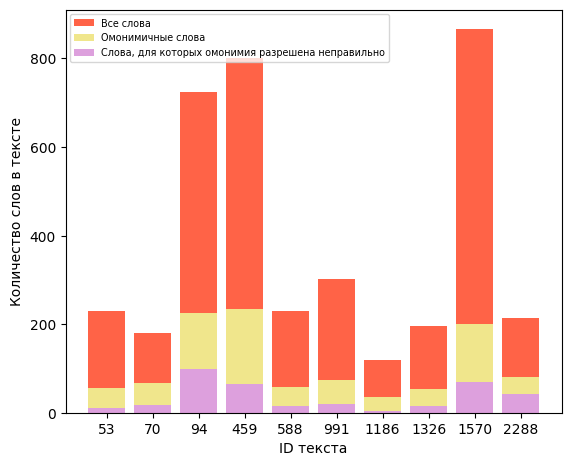

In [8]:
x = np.array(list(map(str, total_words.keys())))
y1 = np.array(list(total_words.values()))
y2 = np.array(list(homonymic_words.values()))
y3 = np.array(list(incorrectly_predicted_words.values()))
y1 -= y2
y2 -= y3

plt.bar(x, y1, bottom=y2 + y3, color="tomato")
plt.bar(x, y2, bottom=y3, color="khaki")
plt.bar(x, y3, color="plum")
plt.xlabel("ID текста")
plt.ylabel("Количество слов в тексте")
plt.legend(
    [
        "Все слова",
        "Омонимичные слова",
        "Слова, для которых омонимия разрешена неправильно",
    ],
    fontsize="x-small",
)
plt.subplots_adjust(top=0.95)
plt.savefig("1.png")

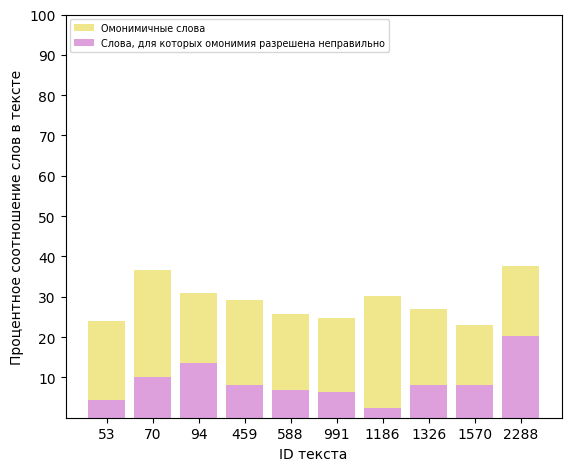

In [9]:
total_words_list = np.array(list(total_words.values()))
x = np.array(list(map(str, total_words.keys())))
y1 = np.array(list(homonymic_words.values())) / total_words_list * 100
y2 = np.array(list(incorrectly_predicted_words.values())) / total_words_list * 100
y1 -= y2

plt.bar(x, y1, bottom=y2, color="khaki")
plt.bar(x, y2, color="plum")
plt.yticks(range(10, 101, 10))
plt.xlabel("ID текста")
plt.ylabel("Процентное соотношение слов в тексте")
plt.legend(
    ["Омонимичные слова", "Слова, для которых омонимия разрешена неправильно"],
    fontsize="x-small",
    loc="upper left",
)
plt.subplots_adjust(top=0.95)
plt.savefig("2.png")

In [10]:
print(
    "Токены, которые не были найдены в размеченном тексте\n"
    "(из-за различных подходов к токенизации)\n\n"
    "ID текста : Номер предложения : Токен"
)

for text_id, text_list in token_not_found.items():
    for token in text_list:
        print("{:<9} : {:<17} : {}".format(text_id, token[0], token[1]))

Токены, которые не были найдены в размеченном тексте
(из-за различных подходов к токенизации)

ID текста : Номер предложения : Токен
94        : 25                : и
94        : 25                : Таи
94        : 27                : Ваа
94        : 27                : о
94        : 27                : Фоноти
459       : 60                : я
459       : 99                : а
1570      : 71                : местно
1570      : 71                : анестезирующих
1570      : 116               : Хромато
1570      : 124               : хромато
2288      : 4                 : Мандо
2288      : 4                 : аде
2288      : 4                 : мандо
2288      : 4                 : а
2288      : 14                : Альфа
2288      : 15                : Холстис


In [11]:
lemmas_sorted = sorted(lemmas_statistics_total.items(), key=lambda x: x[1], reverse=True)[:15]

print("15 самых частых омонимичных слов")
for lemma in lemmas_sorted:
    print(f"{lemma[0]:<10} : {lemma[1]}")

15 самых частых омонимичных слов
в          : 157
на         : 49
и          : 46
с          : 45
я          : 35
к          : 24
о          : 21
есть       : 19
из         : 19
до         : 17
мандалорец : 16
этот       : 15
год        : 14
другой     : 13
у          : 12


In [12]:
lemmas_sorted = sorted(lemmas_statistics_good.items(), key=lambda x: x[1], reverse=True)[:15]

print("15 слов, для которых омонимия чаще всего разрешается ПРАВИЛЬНО")
for lemma in lemmas_sorted:
    print(f"{lemma[0]:<10} : {lemma[1]}")

15 слов, для которых омонимия чаще всего разрешается ПРАВИЛЬНО
в          : 154
на         : 47
с          : 45
и          : 45
я          : 34
к          : 24
о          : 21
из         : 19
до         : 15
год        : 14
есть       : 14
у          : 11
этот       : 9
а          : 8
другой     : 8


In [13]:
lemmas_sorted = sorted(lemmas_statistics_bad.items(), key=lambda x: x[1], reverse=True)[:15]

print("15 слов, для которых омонимия чаще всего разрешается НЕПРАВИЛЬНО")
for lemma in lemmas_sorted:
    print(f"{lemma[0]:<10} : {lemma[1]}")

15 слов, для которых омонимия чаще всего разрешается НЕПРАВИЛЬНО
мандалорец : 16
также      : 8
тот        : 6
глава      : 6
вид        : 6
этот       : 6
новый      : 5
мир        : 5
весь       : 5
другой     : 5
нет        : 5
свой       : 5
есть       : 5
кока       : 5
округ      : 4


In [14]:
print(
    "Статистика по частям речи\n\n"
    "Часть речи                       : Всего : Правильно : Неправильно : %"
)

tags_sorted = sorted(tags_statistics_total.items(), key=lambda x: x[1], reverse=True)
pos = {}
pos_russian_names = {
    "A": "прилагательное",
    "ADV": "наречие",
    "ADVPRO": "местоименное наречие",
    "ANUM": "числительное-прилагательное",
    "APRO": "местоименное прилагательное",
    "COM": "часть композита - сложного слова",
    "CONJ": "союз",
    "INTJ": "междометие",
    "NUM": "числительное",
    "PART": "частица",
    "PR": "предлог",
    "S": "существительное",
    "SPRO": "местоименное существительное",
    "V": "глагол"
}
for tag, total in tags_sorted:
    if tag not in [
        "A", "ADV", "ADVPRO", "ANUM", "APRO", "COM", "CONJ", "INTJ", "NUM", "PART", "PR", "S", "SPRO", "V", "союз", "междометие",
    ]:
        continue
        
    good = tags_statistics_good.get(tag, 0)
    pos_russian_name = pos_russian_names.get(tag, tag)
    pos[pos_russian_name] = good / total * 100
        
    print(
        "{:<32} : {:<5} : {:<9} : {:<11} : {}".format(
            pos_russian_names.get(tag, tag),
            total,
            tags_statistics_good.get(tag, 0),
            total - good,
            round((good / total) * 100)
        )
    )

Статистика по частям речи

Часть речи                       : Всего : Правильно : Неправильно : %
предлог                          : 371   : 365       : 6           : 98
существительное                  : 223   : 130       : 93          : 58
местоименное прилагательное      : 113   : 48        : 65          : 42
союз                             : 84    : 77        : 7           : 92
глагол                           : 50    : 21        : 29          : 42
местоименное существительное     : 50    : 37        : 13          : 74
местоименное наречие             : 34    : 31        : 3           : 91
частица                          : 25    : 14        : 11          : 56
часть композита - сложного слова : 11    : 0         : 11          : 0
междометие                       : 1     : 1         : 0           : 100


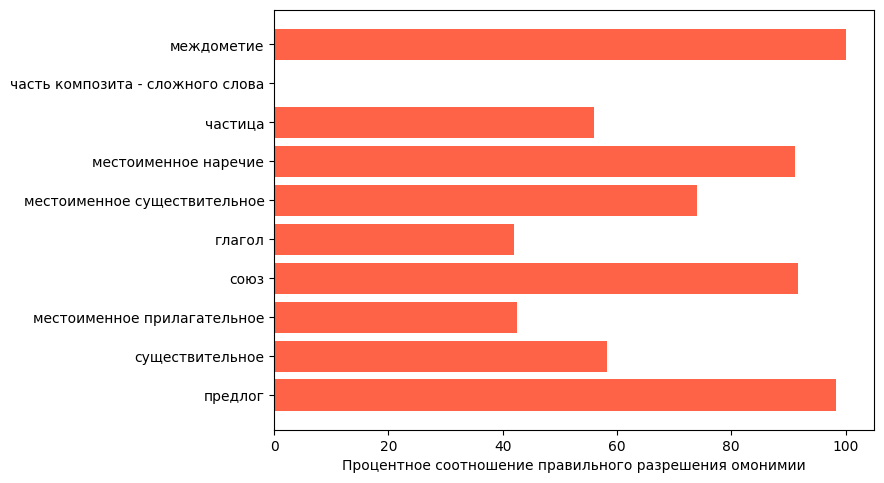

In [22]:
x = np.array(list(pos.keys()))
y = np.array(list(pos.values()))

plt.barh(x, y, color="tomato")
plt.xlabel("Процентное соотношение правильного разрешения омонимии")
plt.rcParams["figure.figsize"] = (10, 5)
plt.subplots_adjust(left=0.3, top=0.95)
plt.savefig("3.png")

In [19]:
print(
    "Статистика по другим тегам\n\n"
    "Тег        : Всего : Правильно : Неправильно : %"
)

tags = {}

for tag, total in tags_sorted:
    if tag in [
        "A", "ADV", "ADVPRO", "ANUM", "APRO", "COM", "CONJ", "INTJ", "NUM", "PART", "PR", "S", "SPRO", "V", "союз", "междометие", ""
    ]:
        continue
        
    good = tags_statistics_good.get(tag, 0)
    tags[tag] = good / total * 100
        
    print(
        "{:<10} : {:<5} : {:<9} : {:<11} : {}".format(
            tag,
            total,
            good,
            total - good,
            round((good / total) * 100)
        )
    )

Статистика по другим тегам

Тег        : Всего : Правильно : Неправильно : %
ед         : 295   : 156       : 139         : 53
неод       : 157   : 94        : 63          : 60
мн         : 156   : 80        : 76          : 51
муж        : 142   : 77        : 65          : 54
им         : 135   : 92        : 43          : 68
жен        : 116   : 68        : 48          : 59
род        : 101   : 38        : 63          : 38
од         : 74    : 38        : 36          : 51
сред       : 54    : 24        : 30          : 44
изъяв      : 49    : 21        : 28          : 43
несов      : 46    : 19        : 27          : 41
пр         : 42    : 31        : 11          : 74
твор       : 41    : 18        : 23          : 44
вин        : 40    : 31        : 9           : 78
нп         : 40    : 18        : 22          : 45
1-л        : 40    : 35        : 5           : 88
прош       : 35    : 20        : 15          : 57
3-л        : 29    : 3         : 26          : 10
наст       : 28    : 0 

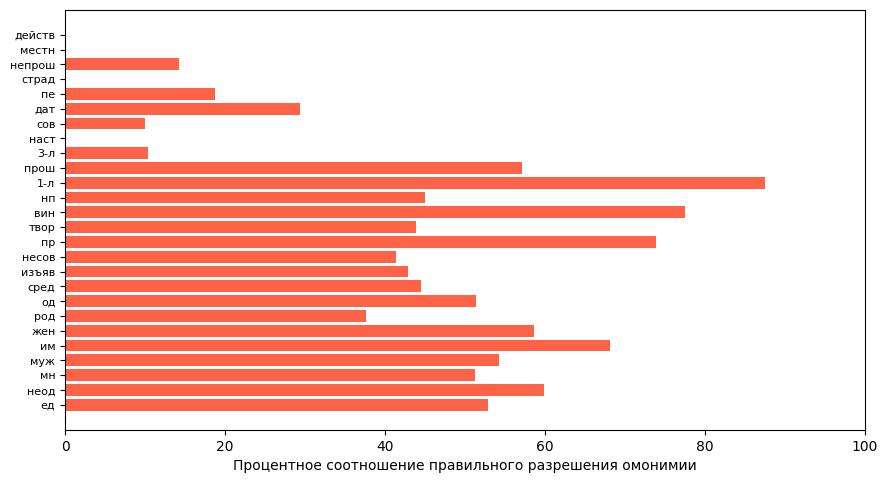

In [20]:
x = np.array(list(tags.keys()))
y = np.array(list(tags.values()))

plt.barh(x, y, color="tomato")
plt.xlabel("Процентное соотношение правильного разрешения омонимии")
plt.rcParams["figure.figsize"] = (8, 5)
plt.xticks(range(0, 101, 20))
plt.tick_params(axis='y', labelsize=8)
plt.subplots_adjust(left=0.1, top=0.95)
plt.savefig("4.png")